
### <center>**Online Job Recruitment Scam Detection**

**Importing Important Libraries**

In [ ]:
import pandas as pd
import numpy as np
import nltk
import re
import seaborn as sns
import plotly.express as px
import spacy
import matplotlib.pyplot as plt
from spacy.lang.en.stop_words import STOP_WORDS
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer 
from sklearn.model_selection import cross_val_score

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

**Uploading Data to Colab**

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving DataSet.csv to DataSet.csv


## **1. Understanding the data**

In [ ]:
data = pd.read_csv('/content/DataSet.csv')
data.head()

,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,in_balanced_dataset
0,Marketing Intern,"US, NY, New York",Marketing,NaN,"<h3>We're Food52, and we've created a groundbr...","<p>Food52, a fast-growing, James Beard Award-w...",<ul>\r\n<li>Experience with content management...,NaN,f,t,f,Other,Internship,NaN,NaN,Marketing,f,f
1,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"<h3>90 Seconds, the worlds Cloud Video Product...",<p>Organised - Focused - Vibrant - Awesome!<br...,<p><b>What we expect from you:</b></p>\r\n<p>Y...,<h3><b>What you will get from us</b></h3>\r\n<...,f,t,f,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,f,f
2,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,<h3></h3>\r\n<p>Valor Services provides Workfo...,"<p>Our client, located in Houston, is actively...",<ul>\r\n<li>Implement pre-commissioning and co...,NaN,f,t,f,NaN,NaN,NaN,NaN,NaN,f,f
3,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,<p>Our passion for improving quality of life t...,<p><b>THE COMPANY: ESRI – Environmental System...,<ul>\r\n<li>\r\n<b>EDUCATION: </b>Bachelor’s o...,<p>Our culture is anything but corporate—we ha...,f,t,f,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,f,f
4,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,<p>SpotSource Solutions LLC is a Global Human ...,<p><b>JOB TITLE:</b> Itemization Review Manage...,<p><b>QUALIFICATIONS:</b></p>\r\n<ul>\r\n<li>R...,<p>Full Benefits Offered</p>,f,t,t,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,f,f


In [ ]:
print(data.shape,end='\n\n')
print(data.info())

(17880, 18)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   title                17880 non-null  object
 1   location             17534 non-null  object
 2   department           6333 non-null   object
 3   salary_range         2868 non-null   object
 4   company_profile      14572 non-null  object
 5   description          17880 non-null  object
 6   requirements         15191 non-null  object
 7   benefits             10684 non-null  object
 8   telecommuting        17880 non-null  object
 9   has_company_logo     17880 non-null  object
 10  has_questions        17880 non-null  object
 11  employment_type      14409 non-null  object
 12  required_experience  10830 non-null  object
 13  required_education   9775 non-null   object
 14  industry             12977 non-null  object
 15  function             11425 non-null  obj

In [ ]:
data.isna().sum()

title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                0
requirements            2689
benefits                7196
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
in_balanced_dataset        0
dtype: int64

## **2. Exploratory Data Analysis**

**HeatMap showing the missing values in each column**

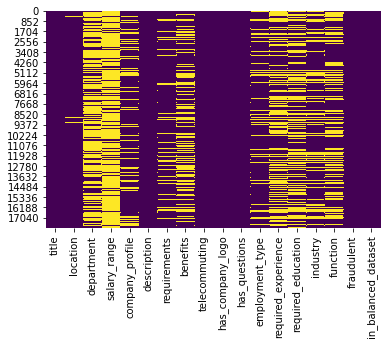

In [ ]:
sns.heatmap(data.isnull(),cbar=False,cmap='viridis')

**Correlation of Categorical Columns with fraudelent**

In [ ]:
l = cat_cols.corr().values
cols = cat_cols.columns
i=0
print("Correlation of Categorical Columns with fraudelent:")
for col in cols:
  print(col,": ",l[i][-1])
  i+=1
  if(i==8):
    break

Correlation of Categorical Columns with fraudelent:
telecommuting :  0.03452287687711348
has_company_logo :  -0.2619713430431789
has_questions :  -0.09162725935730665
employment_type :  -0.017720283670487228
required_experience :  -0.03438256840510067
required_education :  0.016659083018707378
industry :  0.009063041138868654
function :  -0.07415463037348091


**Most seen titles**

In [ ]:
print("Value counts of most seen titles in fraudulent class:\n",data[data.fraudulent=='t'].title.value_counts()[:10],end='\n\n')
print("Top 10 occurences in Title and value counts:")
data.title.value_counts()[:10]

Value counts of most seen titles in fraudulent class:
 Home Based Payroll Typist/Data Entry Clerks Positions Available         21
Data Entry Admin/Clerical Positions - Work From Home                    21
Cruise Staff Wanted *URGENT*                                            21
Customer Service Representative                                         17
Administrative Assistant                                                16
Home Based Payroll Data Entry Clerk Position - Earn $100-$200 Daily     12
Account Sales Managers $80-$130,000/yr                                  10
Payroll Clerk                                                           10
Payroll Data Coordinator Positions - Earn $100-$200 Daily               10
Network Marketing                                                       10
Name: title, dtype: int64

Top 10 occurences in Title and value counts:


English Teacher Abroad                                311
Customer Service Associate                            146
Graduates: English Teacher Abroad (Conversational)    144
English Teacher Abroad                                 95
Software Engineer                                      86
English Teacher Abroad (Conversational)                83
Customer Service Associate - Part Time                 76
Account Manager                                        75
Web Developer                                          66
Project Manager                                        62
Name: title, dtype: int64

**Fradulent and Genuine data count**

In [ ]:
value=pd.DataFrame(data["fraudulent"].value_counts())
px.bar(value,y='fraudulent')

**Frequency of Word Tokens**

Fraudulent jobs word cloud

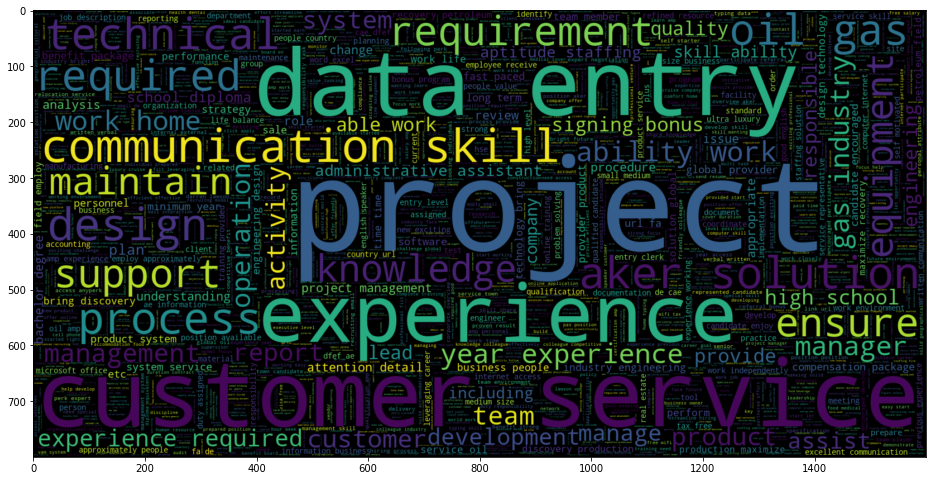

In [ ]:
#Separate fraud and actual jobs
fraudjobs_text = final[final.fraudulent=='t'].Text
#actualjobs_text = data[data.fraudulent==0].text

#Fraudulent jobs word cloud
STOPWORDS = spacy.lang.en.stop_words.STOP_WORDS
plt.figure(figsize = (16,14))
wc = WordCloud(min_font_size = 3,  max_words = 3000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(str(" ".join(fraudjobs_text)))
plt.imshow(wc,interpolation = 'bilinear')

Genuine jobs word cloud

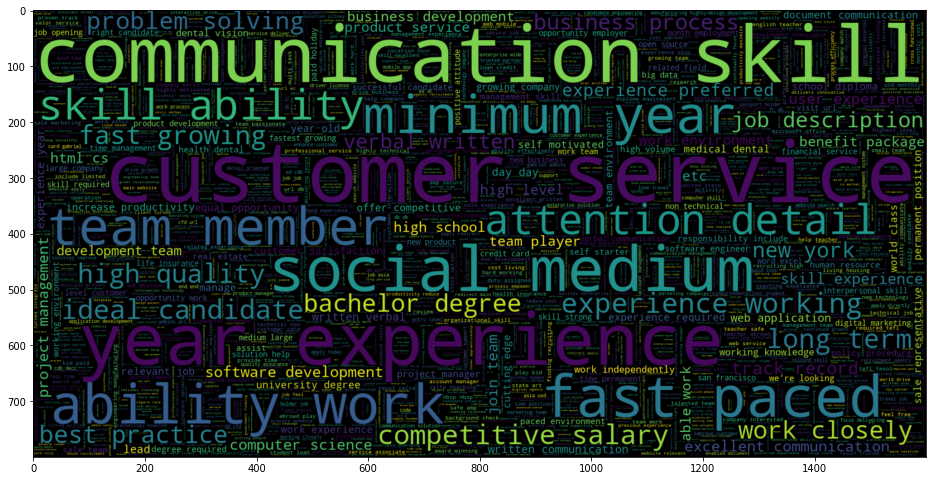

In [ ]:
actualjobs_text = final[final.fraudulent=='f'].Text
STOPWORDS = spacy.lang.en.stop_words.STOP_WORDS
plt.figure(figsize = (16,14))
wc = WordCloud(min_font_size = 3,  max_words = 3000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(str(" ".join(actualjobs_text)))
plt.imshow(wc,interpolation = 'bilinear')

In [ ]:
data.sample(5)

,title,location,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,in_balanced_dataset
15238,Graphite Expert (Remote Position),"US, CA, San Francisco",,\r\nPosition: Graphite Expert\r\nLocation: San...,Offshore or onsite is ok.\r\n Duration : Max 3...,,f,f,f,Contract,,,,,t,f
595,UI/UX Designer,"GB, LND, London",Want to build a 21st century financial service...,TransferWise is the clever new way to move mon...,"\r\nOwn and develop a beautiful, consistent us...","\r\nCompetitive salary, depending on experienc...",f,t,f,,,,,,f,f
13256,Back-end Engineer - StageBloc,"US, IL, Chicago",The story of the Great Chicago Fire of 1871 is...,About StageBloc\r\nStageBloc is a platform tha...,\r\nWork as part of StageBloc’s core developme...,,f,t,f,Full-time,Mid-Senior level,Bachelor's Degree,Information Technology and Services,Engineering,f,f
2353,Apprentice Office Administrator 16-18 Year Old...,"GB, UKM, Bradford",Established on the principles that full time e...,Government funding is only available for 16-18...,"Candidates must have IT, literacy, and numerac...",Career opportunities,f,t,t,,,,,,f,f
5264,Manchester Business Admin Apprenticeship Under...,"GB, MAN,",Established on the principles that full time e...,Government funding is only available for 16-18...,16-18 year olds only due to government funding...,Career prospects.,f,t,t,,Not Applicable,High School or equivalent,Legal Services,Administrative,f,f


## **3. Data Preprocessing**

**Removing Unwanted Columns from the raw data**

In [ ]:
data.drop(columns=['department','salary_range'],axis = 1,inplace=True)

In [ ]:
data.fillna('',inplace=True)

**Taking all catagorical variables in one data frame**

In [ ]:
cat_cols = data.loc[:,['telecommuting', 'has_company_logo', 'has_questions',
       'employment_type', 'required_experience', 'required_education',
       'industry', 'function', 'fraudulent']]

**Encoding categorical variables**

In [ ]:
from sklearn.preprocessing import LabelEncoder
for col in cat_cols.columns:
  le = LabelEncoder()
  cat_cols[col] = le.fit_transform(cat_cols[col])

Removing HTML Tags

In [ ]:
cols = ['company_profile'	,'description',	'requirements',	'benefits']

for col in cols:
  for i in range(len(data[col])):
    TAG_RE = re.compile(r'<[^>]+>')
    data[col][i] = TAG_RE.sub('', data[col][i])

## 4. **DataSampling**

In [ ]:
shuffled_data = data.sample(frac=1,random_state=4)
# Put all the fraud class in a separate dataset.
fraud_data = shuffled_data.loc[shuffled_data['fraudulent'] == 't']
#Randomly select 866 observations from the non-fraud (majority class)
non_fraud_data = shuffled_data.loc[shuffled_data['fraudulent'] == 'f'].sample(n=866,random_state=42)
# Concatenate both dataframes again
data = pd.concat([fraud_data, non_fraud_data])

In [ ]:
data.shape

(1732, 16)

### **Final Data**

In [ ]:
final = pd.DataFrame(data['fraudulent'])

In [ ]:
final['Text'] = data['title']+' '+data['company_profile']+' '+data['description']+' '+data['requirements']+' '+data['benefits']

In [ ]:
final.shape

(1732, 2)

In [ ]:
final.head()
final.reset_index(inplace=True)

**Label Encoding Dependent Variable**

In [ ]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
final.fraudulent = encoder.fit_transform(final.fraudulent)

### **Cleaning The Text Data**

**stopwords.words is used for removing english stop words**

In [ ]:
all_stopwords = stopwords.words('english')
print(all_stopwords)
all_stopwords.remove('not')
all_stopwords.remove('no')
all_stopwords.remove('nor')

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

Regular Expression is used for only keeping letters and removing all special charecters and numbers

lower() is used to normalise the words to lower case

WordNetLemmatizer() is used to lemmatize the words back to its normal form

In [ ]:
for i in range(0,final.shape[0]):
  sample = final['Text'][i]
  lemmatizer = WordNetLemmatizer()
  sample = re.sub("[^a-zA-Z']", ' ', sample)
  sample = re.sub(r"can\'t",'can not',sample)
  sample = re.sub(r"n\'t", " not", sample)
  sample = sample.lower()
  sample = sample.split()
  sample = [lemmatizer.lemmatize(word) for word in sample if not word in set(all_stopwords)]
  sample = ' '.join(sample)
  final['Text'][i] = sample

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
final.sample(5)

,index,fraudulent,Text
211,10961,1,lead software engineer web aptitude staffing s...
536,5697,1,construction engineer choose aecom imagine wor...
1018,16641,0,technical architect rapidvalue leading provide...
1573,6204,0,lead designer highlight fun simple way learn p...
807,16552,1,nursing therapy position home care nursing amp...


## **5. Classifcation using Machine Learning Algorithms**

### **uni gram**

In [ ]:
X = final.Text
y = final.fraudulent
from sklearn.feature_extraction.text import CountVectorizer
count_vectorize = CountVectorizer(ngram_range=(1,1)) 
X = count_vectorize.fit_transform(X).toarray()

In [ ]:
X.shape

(1732, 15138)

In [ ]:
from sklearn.feature_selection import SelectKBest,chi2

In [ ]:
test = SelectKBest(score_func=chi2, k=8000)
fit = test.fit(X, y)
fit.scores_

array([0.65306122, 4.5       , 1.        , ..., 2.        , 1.        ,
       5.        ])

In [ ]:
X_new = test.fit_transform(X, y)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size = 0.20, random_state = 0)

**Random Forest Classifier**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

forest = RandomForestClassifier()
forest.fit(X_train,y_train)
y_pred = forest.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score
print('Random Forest Classifier')
print('accuracy :',accuracy_score(y_test,y_pred))
print('F1 score :',f1_score(y_test,y_pred))
print('Precision:',precision_score(y_test,y_pred))
print('Recall   :',recall_score(y_test,y_pred))
print('Cross validation score : \n',cross_val_score(estimator = forest, X = X_train, y = y_train, cv =5))
print('Mean of cross validation score : ',cross_val_score(estimator = forest, X = X_train, y = y_train, cv =5).mean())

Random Forest Classifier
accuracy : 0.8962536023054755
F1 score : 0.891566265060241
Precision: 0.891566265060241
Recall   : 0.891566265060241
Cross validation score : 
 [0.92418773 0.92418773 0.90252708 0.89530686 0.86281588]
Mean of cross validation score :  0.9054151624548737


**Random Forest Classifier Uni-Gram with hyperparameter tuning**

In [ ]:
forest = RandomForestClassifier(criterion='entropy',n_estimators = 910, min_samples_split = 2, min_samples_leaf = 1, max_features = 'auto', max_depth = 100, bootstrap = False)
forest.fit(X_train,y_train)
y_pred = forest.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score
print('Random Forest Classifier Uni-Gram with hyperparameter tuning')
print('accuracy :',accuracy_score(y_test,y_pred))
print('F1 score :',f1_score(y_test,y_pred))
print('Precision:',precision_score(y_test,y_pred))
print('Recall   :',recall_score(y_test,y_pred))
print('Cross validation score : \n',cross_val_score(estimator = forest, X = X_train, y = y_train, cv =5))
print('Mean of cross validation score : ',cross_val_score(estimator = forest, X = X_train, y = y_train, cv =5).mean())

Random Forest Classifier Uni-Gram with hyperparameter tuning
accuracy : 0.9135446685878963
F1 score : 0.9090909090909091
Precision: 0.9146341463414634
Recall   : 0.9036144578313253
Cross validation score : 
 [0.95306859 0.93501805 0.91696751 0.91696751 0.87364621]
Mean of cross validation score :  0.9176895306859206


**Support Vector Classifier**

In [ ]:
from sklearn.svm import SVC
svc = SVC()
svc.fit(X_train,y_train)
y_svc = svc.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score
print('Support Vector Classifier')
print('accuracy :',accuracy_score(y_test,y_svc))
print('F1 score :',f1_score(y_test,y_svc))
print('Precision:',precision_score(y_test,y_svc))
print('Recall   :',recall_score(y_test,y_svc))
print('Cross validation score : \n',cross_val_score(estimator = svc, X = X_train, y = y_train, cv =5))
print('Mean of cross validation score : ',cross_val_score(estimator = svc, X = X_train, y = y_train, cv =5).mean())

Support Vector Classifier
accuracy : 0.8760806916426513
F1 score : 0.8685015290519877
Precision: 0.8819875776397516
Recall   : 0.8554216867469879
Cross validation score : 
 [0.91696751 0.9133574  0.88086643 0.88808664 0.8700361 ]
Mean of cross validation score :  0.8938628158844765


**Gaussian Naive Bayes**

In [ ]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_nb = gnb.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score
print('Gaussian Naive Bayes')
print('accuracy :',accuracy_score(y_test,y_nb))
print('F1 score :',f1_score(y_test,y_nb))
print('Precision:',precision_score(y_test,y_nb))
print('Recall   :',recall_score(y_test,y_nb))
print('Cross validation score : \n',cross_val_score(estimator = gnb, X = X_train, y = y_train, cv =5))
print('Mean of cross validation score : ',cross_val_score(estimator = gnb, X = X_train, y = y_train, cv =5).mean())

Gaussian Naive Bayes
accuracy : 0.9250720461095101
F1 score : 0.920245398773006
Precision: 0.9375
Recall   : 0.9036144578313253
Cross validation score : 
 [0.93862816 0.94223827 0.92057762 0.90974729 0.92418773]
Mean of cross validation score :  0.9270758122743683


**LightGBM Classifier**

In [ ]:
import lightgbm as lgb
lgbm = lgb.LGBMClassifier()
lgbm.fit(X_train, y_train)
y_lgbm = lgbm.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score
print('LightGBM Classifier')
print('accuracy :',accuracy_score(y_test,y_lgbm))
print('F1 score :',f1_score(y_test,y_lgbm))
print('Precision:',precision_score(y_test,y_lgbm))
print('Recall   :',recall_score(y_test,y_lgbm))
print('Cross validation score : \n',cross_val_score(estimator = lgbm, X = X_train, y = y_train, cv =5))
print('Mean of cross validation score : ',cross_val_score(estimator = lgbm, X = X_train, y = y_train, cv =5).mean())

LightGBM Classifier
accuracy : 0.9020172910662824
F1 score : 0.9
Precision: 0.8793103448275862
Recall   : 0.9216867469879518
Cross validation score : 
 [0.93862816 0.92057762 0.90974729 0.92779783 0.87725632]
Mean of cross validation score :  0.9148014440433213


**Light GBM Classifier Uni-Gram with hyperparameter tuning**

In [ ]:
import lightgbm as lgb
lgbm = lgb.LGBMClassifier(subsample = 0.7000000000000001, random_state = 501, objective= 'binary', num_leaves= 30, min_split_gain = 0.4, min_data_in_leaf = 1, metric = 'accuracy', max_depth = 8, learning_rate = 0.04, colsample_bytree = 0.2, boosting_type = 'gbdt')
lgbm.fit(X_train, y_train)
y_lgbm = lgbm.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score
print('LightGBM Classifier')
print('accuracy :',accuracy_score(y_test,y_lgbm))
print('F1 score :',f1_score(y_test,y_lgbm))
print('Precision:',precision_score(y_test,y_lgbm))
print('Recall   :',recall_score(y_test,y_lgbm))
print('Cross validation score : \n',cross_val_score(estimator = lgbm, X = X_train, y = y_train, cv =5))
print('Mean of cross validation score : ',cross_val_score(estimator = lgbm, X = X_train, y = y_train, cv =5).mean())

LightGBM Classifier
accuracy : 0.9135446685878963
F1 score : 0.912280701754386
Precision: 0.8863636363636364
Recall   : 0.9397590361445783
Cross validation score : 
 [0.92418773 0.90252708 0.89530686 0.9133574  0.86281588]
Mean of cross validation score :  0.8996389891696751


**XGBoost Classifier**

In [ ]:
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(X_train, y_train)
y_xgb = xgb.predict(X_test)    

In [ ]:
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score
print('XGBoost Classifier')
print('accuracy :',accuracy_score(y_test,y_xgb))
print('F1 score :',f1_score(y_test,y_xgb))
print('Precision:',precision_score(y_test,y_xgb))
print('Recall   :',recall_score(y_test,y_xgb))
print('Cross validation score : \n',cross_val_score(estimator = xgb, X = X_train, y = y_train, cv =5))
print('Mean of cross validation score : ',cross_val_score(estimator = xgb, X = X_train, y = y_train, cv =5).mean())

XGBoost Classifier
accuracy : 0.8876080691642652
F1 score : 0.8882521489971348
Precision: 0.8469945355191257
Recall   : 0.9337349397590361
Cross validation score : 
 [0.90974729 0.89530686 0.88086643 0.88447653 0.8700361 ]
Mean of cross validation score :  0.8880866425992779


### **Bi gram**

In [ ]:
X = final.Text
y = final.fraudulent
from sklearn.feature_extraction.text import CountVectorizer
count_vectorize = CountVectorizer(ngram_range=(2,2)) 
X = count_vectorize.fit_transform(X).toarray()

In [ ]:
test = SelectKBest(score_func=chi2, k=8000)
fit = test.fit(X, y)
fit.scores_

array([0., 1., 1., ..., 1., 1., 5.])

In [ ]:
X_new = test.fit_transform(X, y)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size = 0.20, random_state = 0)

**Random Forest Classifier**

In [ ]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier()
forest.fit(X_train,y_train)
y_pred = forest.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score
print('Random Forest Classifier')
print('accuracy :',accuracy_score(y_test,y_pred))
print('F1 score :',f1_score(y_test,y_pred))
print('Precision:',precision_score(y_test,y_pred))
print('Recall   :',recall_score(y_test,y_pred))
print('Cross validation score : \n',cross_val_score(estimator = forest, X = X_train, y = y_train, cv =5))
print('Mean of cross validation score : ',cross_val_score(estimator = forest, X = X_train, y = y_train, cv =5).mean())

Random Forest Classifier
accuracy : 0.9077809798270894
F1 score : 0.9069767441860466
Precision: 0.8764044943820225
Recall   : 0.9397590361445783
Cross validation score : 
 [0.9133574  0.92418773 0.87725632 0.92057762 0.89891697]
Mean of cross validation score :  0.9083032490974728


**Random Forest Classifier Bi-Gram with hyperparameter tuning**

In [ ]:
forest = RandomForestClassifier(criterion='entropy',n_estimators = 910, min_samples_split = 2, min_samples_leaf = 1, max_features = 'auto', max_depth = 100, bootstrap = False)
forest.fit(X_train,y_train)
y_pred = forest.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score
print('Random Forest Classifier Bi-Gram with hyperparameter tuning')
print('accuracy :',accuracy_score(y_test,y_pred))
print('F1 score :',f1_score(y_test,y_pred))
print('Precision:',precision_score(y_test,y_pred))
print('Recall   :',recall_score(y_test,y_pred))
print('Cross validation score : \n',cross_val_score(estimator = forest, X = X_train, y = y_train, cv =5))
print('Mean of cross validation score : ',cross_val_score(estimator = forest, X = X_train, y = y_train, cv =5).mean())

Random Forest Classifier Bi-Gram with hyperparameter tuning
accuracy : 0.9164265129682997
F1 score : 0.9090909090909091
Precision: 0.9477124183006536
Recall   : 0.8734939759036144
Cross validation score : 
 [0.94223827 0.90613718 0.88447653 0.91696751 0.90613718]
Mean of cross validation score :  0.9126353790613717


Support Vector **Classifier**

In [ ]:
from sklearn.svm import SVC
svc = SVC()
svc.fit(X_train,y_train)
y_svc = svc.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score
print('Support Vector Classifier')
print('accuracy :',accuracy_score(y_test,y_svc))
print('F1 score :',f1_score(y_test,y_svc))
print('Precision:',precision_score(y_test,y_svc))
print('Recall   :',recall_score(y_test,y_svc))
print('Cross validation score : \n',cross_val_score(estimator = svc, X = X_train, y = y_train, cv =5))
print('Mean of cross validation score : ',cross_val_score(estimator = svc, X = X_train, y = y_train, cv =5).mean())

Support Vector Classifier
accuracy : 0.9164265129682997
F1 score : 0.91131498470948
Precision: 0.9254658385093167
Recall   : 0.8975903614457831
Cross validation score : 
 [0.93140794 0.90974729 0.90974729 0.94223827 0.9133574 ]
Mean of cross validation score :  0.9212996389891697


**Gaussian Naive Bayes**

In [ ]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_nb = gnb.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score
print('Gaussian Naive Bayes')
print('accuracy :',accuracy_score(y_test,y_nb))
print('F1 score :',f1_score(y_test,y_nb))
print('Precision:',precision_score(y_test,y_nb))
print('Recall   :',recall_score(y_test,y_nb))
print('Cross validation score : \n',cross_val_score(estimator = gnb, X = X_train, y = y_train, cv =5))
print('Mean of cross validation score : ',cross_val_score(estimator = gnb, X = X_train, y = y_train, cv =5).mean())


Gaussian Naive Bayes
accuracy : 0.9481268011527377
F1 score : 0.9437500000000001
Precision: 0.9805194805194806
Recall   : 0.9096385542168675
Cross validation score : 
 [0.95306859 0.96389892 0.93862816 0.95306859 0.94584838]
Mean of cross validation score :  0.9509025270758122


**LightGBM Classifier**

In [ ]:
import lightgbm as lgb
lgbm = lgb.LGBMClassifier()
lgbm.fit(X_train, y_train)
y_lgbm = lgbm.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score
print('LightGBM Classifier')
print('accuracy :',accuracy_score(y_test,y_lgbm))
print('F1 score :',f1_score(y_test,y_lgbm))
print('Precision:',precision_score(y_test,y_lgbm))
print('Recall   :',recall_score(y_test,y_lgbm))
print('Cross validation score : \n',cross_val_score(estimator = lgbm, X = X_train, y = y_train, cv =5))
print('Mean of cross validation score : ',cross_val_score(estimator = lgbm, X = X_train, y = y_train, cv =5).mean())

LightGBM Classifier
accuracy : 0.8760806916426513
F1 score : 0.8724035608308606
Precision: 0.8596491228070176
Recall   : 0.8855421686746988
Cross validation score : 
 [0.89530686 0.86642599 0.81949458 0.89169675 0.88447653]
Mean of cross validation score :  0.8714801444043321


**LightGBM Classifier Bi-Gram with hyperparameter tuning**

In [ ]:
import lightgbm as lgb
lgbm = lgb.LGBMClassifier(subsample = 0.7000000000000001, random_state = 501, objective= 'binary', num_leaves= 30, min_split_gain = 0.4, min_data_in_leaf = 1, metric = 'accuracy', max_depth = 8, learning_rate = 0.04, colsample_bytree = 0.2, boosting_type = 'gbdt')
lgbm.fit(X_train, y_train)
y_lgbm = lgbm.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score
print('LightGBM Classifier')
print('accuracy :',accuracy_score(y_test,y_lgbm))
print('F1 score :',f1_score(y_test,y_lgbm))
print('Precision:',precision_score(y_test,y_lgbm))
print('Recall   :',recall_score(y_test,y_lgbm))
print('Cross validation score : \n',cross_val_score(estimator = lgbm, X = X_train, y = y_train, cv =5))
print('Mean of cross validation score : ',cross_val_score(estimator = lgbm, X = X_train, y = y_train, cv =5).mean())

LightGBM Classifier
accuracy : 0.8703170028818443
F1 score : 0.8543689320388351
Precision: 0.9230769230769231
Recall   : 0.7951807228915663
Cross validation score : 
 [0.90613718 0.89169675 0.84115523 0.88086643 0.86281588]
Mean of cross validation score :  0.8765342960288809


**XGBoost Classifier**

In [ ]:
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(X_train, y_train)
y_xgb = xgb.predict(X_test)    

In [ ]:
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score
print('XGBoost Classifier')
print('accuracy :',accuracy_score(y_test,y_xgb))
print('F1 score :',f1_score(y_test,y_xgb))
print('Precision:',precision_score(y_test,y_xgb))
print('Recall   :',recall_score(y_test,y_xgb))
print('Cross validation score : \n',cross_val_score(estimator = xgb, X = X_train, y = y_train, cv =5))
print('Mean of cross validation score : ',cross_val_score(estimator = xgb, X = X_train, y = y_train, cv =5).mean())

XGBoost Classifier
accuracy : 0.8760806916426513
F1 score : 0.8626198083067093
Precision: 0.9183673469387755
Recall   : 0.8132530120481928
Cross validation score : 
 [0.86281588 0.86642599 0.7833935  0.86281588 0.84476534]
Mean of cross validation score :  0.8440433212996389


### **Tri -Gram**

In [ ]:
X = final.Text
y = final.fraudulent
from sklearn.feature_extraction.text import CountVectorizer
count_vectorize = CountVectorizer(ngram_range=(3,3)) 
X = count_vectorize.fit_transform(X).toarray()

In [ ]:
from sklearn.feature_selection import SelectKBest,chi2
test = SelectKBest(score_func=chi2, k=15000)
fit = test.fit(X, y)
fit.scores_

array([1., 1., 1., ..., 1., 2., 3.])

In [ ]:
X_new = test.fit_transform(X, y)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size = 0.20, random_state = 0)

**RandomForestClassifier**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

forest = RandomForestClassifier(criterion='entropy')
forest.fit(X_train,y_train)
y_pred = forest.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score
print('Random Forest Classifier Tri-Gram without hyperparameter tuning')
print('accuracy :',accuracy_score(y_test,y_pred))
print('F1 score :',f1_score(y_test,y_pred))
print('Precision:',precision_score(y_test,y_pred))
print('Recall   :',recall_score(y_test,y_pred))
scores = cross_val_score(forest,X_new,y,cv=5)
scores
print("5-fold cross validation score (Random forest - Tri gram):",scores.mean())  

Random Forest Classifier Tri-Gram without hyperparameter tuning
accuracy : 0.899135446685879
F1 score : 0.889589905362776
Precision: 0.9337748344370861
Recall   : 0.8493975903614458
5-fold cross validation score (Random forest - Tri gram): 0.9145474838000366


**Random Forest Classifier Tri-Gram with hyperparameter tuning**

In [ ]:
forest.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'entropy',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [ ]:
forest = RandomForestClassifier(criterion='entropy',n_estimators = 910, min_samples_split = 2, min_samples_leaf = 1, max_features = 'auto', max_depth = 100, bootstrap = False)
forest.fit(X_train,y_train)
y_pred = forest.predict(X_test)


In [ ]:
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score
print('Random Forest Classifier Tri-Gram with hyperparameter tuning')
print('accuracy :',accuracy_score(y_test,y_pred))
print('F1 score :',f1_score(y_test,y_pred))
print('Precision:',precision_score(y_test,y_pred))
print('Recall   :',recall_score(y_test,y_pred))
scores = cross_val_score(forest,X_new,y,cv=5)
print("5-fold cross validation score (Random forest - Tri gram):",scores.mean())  

Random Forest Classifier Tri-Gram with hyperparameter tuning
accuracy : 0.8760806916426513
F1 score : 0.8561872909698997
Precision: 0.9624060150375939
Recall   : 0.7710843373493976


KeyboardInterrupt: ignored

**Support vector classifier**

In [ ]:
from sklearn.svm import SVC

svc = SVC()
svc.fit(X_train,y_train)
y_svc = svc.predict(X_test)
# print(classification_report(y_test,y_pred))

In [ ]:
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score
print('Support Vector Classifier')
print('accuracy :',accuracy_score(y_test,y_svc))
print('F1 score :',f1_score(y_test,y_svc))
print('Precision:',precision_score(y_test,y_svc))
print('Recall   :',recall_score(y_test,y_svc))

Support Vector Classifier
accuracy : 0.8530259365994236
F1 score : 0.8271186440677966
Precision: 0.9457364341085271
Recall   : 0.7349397590361446


In [ ]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(svc,X_new,y,cv=5)
print("5-fold cross validation score (Support vector classifier - Tri gram):",scores.mean())  

5-fold cross validation score (Support vector classifier - Tri gram): 0.8522080258533091


**Guassian NB**

In [ ]:
from sklearn.naive_bayes import GaussianNB,MultinomialNB
gnb = GaussianNB()
gnb.fit(X_train,y_train)
y_gnb = gnb.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score
print('Guassian NB')
print('accuracy :',accuracy_score(y_test,y_gnb))
print('F1 score :',f1_score(y_test,y_gnb))
print('Precision:',precision_score(y_test,y_gnb))
print('Recall   :',recall_score(y_test,y_gnb))

Guassian NB
accuracy : 0.9654178674351584
F1 score : 0.9631901840490796
Precision: 0.98125
Recall   : 0.9457831325301205


In [ ]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(gnb,X_new,y,cv=5)
print("10-fold cross validation score (Guassian - Tri gram):",scores.mean())  

10-fold cross validation score (Guassian - Tri gram): 0.9515100531392114


**Multi-nomial naive bayes**

In [ ]:
mnb = MultinomialNB()
mnb.fit(X_train,y_train)
y_mnb = mnb.predict(X_test)
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score
print('Multi-nomial naive bayes')
print('accuracy :',accuracy_score(y_test,y_mnb))
print('F1 score :',f1_score(y_test,y_mnb))
print('Precision:',precision_score(y_test,y_mnb))
print('Recall   :',recall_score(y_test,y_mnb))

Multi-nomial naive bayes
accuracy : 0.9365994236311239
F1 score : 0.9337349397590361
Precision: 0.9337349397590361
Recall   : 0.9337349397590361


**LightGBM**

In [ ]:
import lightgbm as lgb
lgbm = lgb.LGBMClassifier()
lgbm.fit(X_train, y_train)
y_lgbm = lgbm.predict(X_test)

In [ ]:
print('Light GBM Classifier Tri-Gram without hyperparameter tuning')
print('accuracy :',accuracy_score(y_test,y_lgbm))
print('F1 score :',f1_score(y_test,y_lgbm))
print('Precision:',precision_score(y_test,y_lgbm))
print('Recall   :',recall_score(y_test,y_lgbm))

Light GBM Classifier Tri-Gram without hyperparameter tuning
accuracy : 0.7636887608069164
F1 score : 0.7172413793103449
Precision: 0.8387096774193549
Recall   : 0.6265060240963856


In [ ]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(lgbm, X_new,y,cv=5)
print("5-fold cross validation score (LightGBM - Tri gram):",scores.mean()) 

5-fold cross validation score (LightGBM - Tri gram): 0.774842997784478


**Light GBM Classifier Tri-Gram with hyperparameter tuning**

In [ ]:
import lightgbm as lgb 
d_train = lgb.Dataset(X_train,label = y_train)
params = {}
params['boosting_type'] = 'gbdt'
params['metric'] = 'accuracy'
params['random_state'] = 0
params['metric'] = 'accuracy'
params['sub_feature'] = 0.5
params['num_leaves'] = 30
params['min_data'] = 5
params['max_depth'] = 8
params['subsample'] = 0.7000000000000001
params['random_state'] = 0
params['min_split_gain'] = 0.4
params['min_data_in_leaf'] = 1 
params['colsample_bytree'] = 0.2
lgbm = lgb.train(params, d_train, 100)
y_pred = lgbm.predict(X_test)

In [ ]:
y_lgbm = [round(value) for value in y_pred]

In [ ]:
print('Light GBM Classifier Tri-Gram with hyperparameter tuning')
print('accuracy :',accuracy_score(y_test,y_lgbm))
print('F1 score :',f1_score(y_test,y_lgbm))
print('Precision:',precision_score(y_test,y_lgbm))
print('Recall   :',recall_score(y_test,y_lgbm))

Light GBM Classifier Tri-Gram with hyperparameter tuning
accuracy : 0.8703170028818443
F1 score : 0.8534201954397393
Precision: 0.9290780141843972
Recall   : 0.7891566265060241


**XGBClassifier**

In [ ]:
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(X_train,y_train)
y_pred = xgb.predict(X_test)
y_xgb = [round(value) for value in y_pred]


In [ ]:
print('XGB Classifier')
print('accuracy :',accuracy_score(y_test,y_xgb))
print('F1 score :',f1_score(y_test,y_xgb))
print('Precision:',precision_score(y_test,y_xgb))
print('Recall   :',recall_score(y_test,y_xgb))

XGB Classifier
accuracy : 0.7838616714697406
F1 score : 0.7422680412371133
Precision: 0.864
Recall   : 0.6506024096385542


In [ ]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(xgb,X_new,y,cv=5)
print("5-fold cross validation score (XGB Classifier - Tri gram):",scores.mean()) 

5-fold cross validation score (XGB Classifier - Tri gram): 0.807171294831004


### **TF-IDF**

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(final.Text).toarray()

In [ ]:
X

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.06048745, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [ ]:
print(X.shape)

(1732, 15138)


 `chi`

In [ ]:
from sklearn.feature_selection import SelectKBest,chi2
test = SelectKBest(score_func=chi2, k = 8000)
fit = test.fit(X, y)
X= test.fit_transform(X, y)

 **`TRAIN TEST SPLIT`**

In [ ]:
from sklearn.model_selection import  train_test_split

In [ ]:
x_train,x_test,y_train,y_test=train_test_split(X,y,train_size=0.8,random_state=0)

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score
import time
from sklearn.model_selection import cross_val_score

 **`SVM`**

In [ ]:
start_time = time.time()
clf = svm.SVC()
clf.fit(x_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
y_pred=clf.predict(x_test)
score=accuracy_score(y_test,y_pred)
end_time = time.time()
eta = end_time - start_time
print("Accuracy of SVM : ",score)
print('F1 score :',f1_score(y_test,y_pred))
print('Precision:',precision_score(y_test,y_pred))
print('Recall   :',recall_score(y_test,y_pred))
print("Time taken : ",eta)

Accuracy of SVM :  0.9221902017291066
F1 score : 0.9189189189189191
Precision: 0.9161676646706587
Recall   : 0.9216867469879518
Time taken :  112.28286814689636


In [ ]:
cross=cross_val_score(clf,X,y,cv=5)
cross.mean()

0.9336126334727058

 **`RANDOM FOREST`**

In [ ]:
start_time = time.time()
forest = RandomForestClassifier()
forest.fit(x_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
y_pred = forest.predict(x_test)
end_time = time.time()
score=accuracy_score(y_test,y_pred)
eta = end_time - start_time
print("Accuracy of Random forest : ",score)
print('F1 score :',f1_score(y_test,y_pred))
print('Precision:',precision_score(y_test,y_pred))
print('Recall   :',recall_score(y_test,y_pred))
print("Time taken : ",eta)

Accuracy of Random forest :  0.899135446685879
F1 score : 0.8942598187311178
Precision: 0.896969696969697
Recall   : 0.891566265060241
Time taken :  143.96315169334412


In [ ]:
cross=cross_val_score(forest,X,y)
print(cross)
cross.mean()

[0.9221902  0.87896254 0.90462428 0.90751445 0.93352601]


0.9093634955273109

**Random Forest Classifier with hyperparameter tuning**

In [ ]:
forest = RandomForestClassifier(criterion='entropy',n_estimators = 910, min_samples_split = 2, min_samples_leaf = 1, max_features = 'auto', max_depth = 100, bootstrap = False)
forest.fit(X_train,y_train)
y_pred = forest.predict(X_test)


In [ ]:
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score
print('Random Forest Classifier with hyperparameter tuning')
print('accuracy :',accuracy_score(y_test,y_pred))
print('F1 score :',f1_score(y_test,y_pred))
print('Precision:',precision_score(y_test,y_pred))
print('Recall   :',recall_score(y_test,y_pred))

Random Forest Classifier with hyperparameter tuning
accuracy : 0.8818443804034583
F1 score : 0.8628762541806019
Precision: 0.9699248120300752
Recall   : 0.7771084337349398


 **`XGBOOST`**

In [ ]:
start_time = time.time()
xgb = XGBClassifier()
xgb.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
y_pred = xgb.predict(x_test)
end_time = time.time()
score=accuracy_score(y_test,y_pred)
eta = end_time - start_time
print("Accuracy of XGBOOST : ",score)
print('F1 score :',f1_score(y_test,y_pred))
print('Precision:',precision_score(y_test,y_pred))
print('Recall   :',recall_score(y_test,y_pred))
print("Time taken : ",eta)

Accuracy of XGBOOST :  0.8847262247838616
F1 score : 0.8823529411764707
Precision: 0.8620689655172413
Recall   : 0.9036144578313253
Time taken :  46.17286467552185


In [ ]:
cross=cross_val_score(xgb,X,y,cv=5)
print(cross)
cross.mean()

[0.90201729 0.88760807 0.87861272 0.89595376 0.89595376]


0.8920291182888841

 **`NAIVE BAYES`**

In [ ]:
start_time = time.time()
gnb = GaussianNB()
gnb.fit(x_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [ ]:
y_pred = gnb.predict(x_test)
end_time = time.time()
score=accuracy_score(y_test,y_pred)
eta = end_time - start_time
print("Accuracy of Gaussian NB : ",score)
print('F1 score :',f1_score(y_test,y_pred))
print('Precision:',precision_score(y_test,y_pred))
print('Recall   :',recall_score(y_test,y_pred))
print("Time taken : ",eta)

Accuracy of Gaussian NB :  0.9423631123919308
F1 score : 0.9378881987577641
Precision: 0.967948717948718
Recall   : 0.9096385542168675
Time taken :  24.466992139816284


In [ ]:
cross=cross_val_score(gnb,X,y,cv=5)
print(cross)
cross.mean()

[0.94252874 0.94252874 0.95953757 0.93063584 0.96531792 0.94797688
 0.96531792 0.91907514 0.95375723 0.95953757]


0.948621354062853

In [ ]:
#multinomial nb
start_time = time.time()
mnb = MultinomialNB()
mnb.fit(x_train, y_train)
y_pred = mnb.predict(x_test)
end_time = time.time()
score=accuracy_score(y_test,y_pred)
eta = end_time - start_time
print("Accuracy of Multinomial NB : ",score)
print("Time taken : ",eta)

Accuracy of Multinomial NB :  0.9020172910662824
Time taken :  0.07764506340026855


In [ ]:
cross=cross_val_score(mnb,X,y,cv=5)
print(cross)
cross.mean()

[0.90804598 0.87356322 0.9132948  0.96531792 0.92485549 0.94219653
 0.9017341  0.90751445 0.89595376 0.88439306]


0.9116869311009234

**light gbm**

In [ ]:
start_time = time.time()
lgbm = lgb.LGBMClassifier()
lgbm.fit(x_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [ ]:
  y_pred=lgbm.predict(x_test)
  score=accuracy_score(y_test,y_pred)
  end_time = time.time()
  eta = end_time - start_time
  print("Accuracy of Random forest : ",score)
  print('F1 score :',f1_score(y_test,y_pred))
  print('Precision:',precision_score(y_test,y_pred))
  print('Recall   :',recall_score(y_test,y_pred))
  print("Time taken : ",eta)

Accuracy of Random forest :  0.9106628242074928
F1 score : 0.906906906906907
Precision: 0.9041916167664671
Recall   : 0.9096385542168675
Time taken :  43.57416296005249


In [ ]:
print('Mean of cross validation score : ',cross_val_score(estimator = lgbm, X = X_train, y = y_train, cv =5).mean())

Mean of cross validation score :  0.7617328519855595


In [ ]:
import lightgbm as lgb
lgbm = lgb.LGBMClassifier(subsample = 0.7000000000000001, random_state = 501, objective= 'binary', num_leaves= 30, min_split_gain = 0.4, min_data_in_leaf = 1, metric = 'accuracy', max_depth = 8, learning_rate = 0.04, colsample_bytree = 0.2, boosting_type = 'gbdt')
lgbm.fit(X_train, y_train)
y_lgbm = lgbm.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score
print('LightGBM Classifier')
print('accuracy :',accuracy_score(y_test,y_lgbm))
print('F1 score :',f1_score(y_test,y_lgbm))
print('Precision:',precision_score(y_test,y_lgbm))
print('Recall   :',recall_score(y_test,y_lgbm))
print('Cross validation score : \n',cross_val_score(estimator = lgbm, X = X_train, y = y_train, cv =5))
#print('Mean of cross validation score : ',cross_val_score(estimator = lgbm, X = X_train, y = y_train, cv =5).mean())

LightGBM Classifier
accuracy : 0.829971181556196
F1 score : 0.8026755852842808
Precision: 0.9022556390977443
Recall   : 0.7228915662650602
Cross validation score : 
 [0.84476534 0.81588448 0.82310469 0.85559567 0.82310469]


In [ ]:
cross=cross_val_score(model,X,y,cv=5)
print(cross)
cross.mean()

[0.87931034 0.85632184 0.87283237 0.93641618 0.86127168 0.90751445
 0.89595376 0.86705202 0.89595376 0.86705202]


0.8839678426682613

## **Evaluation**

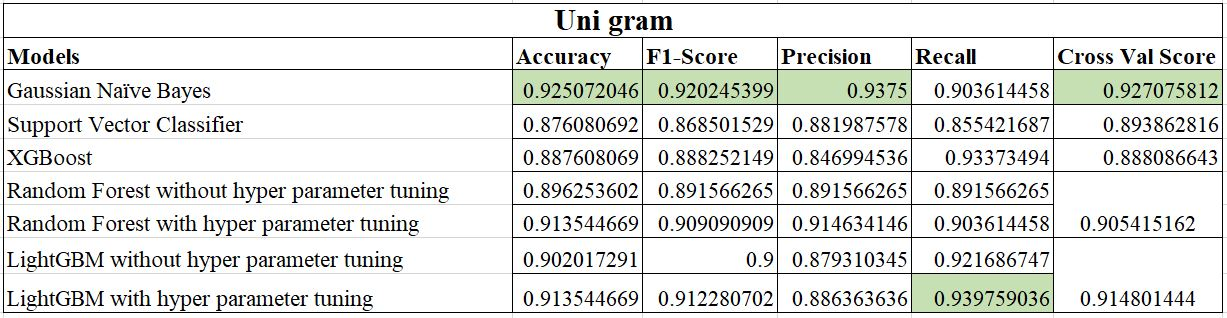

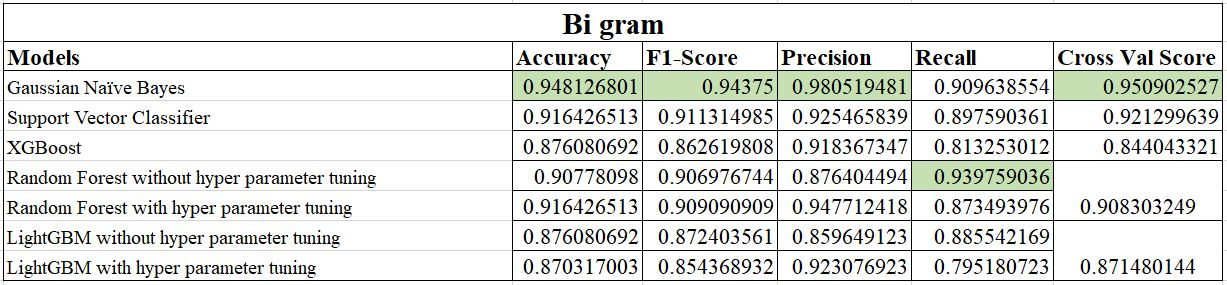

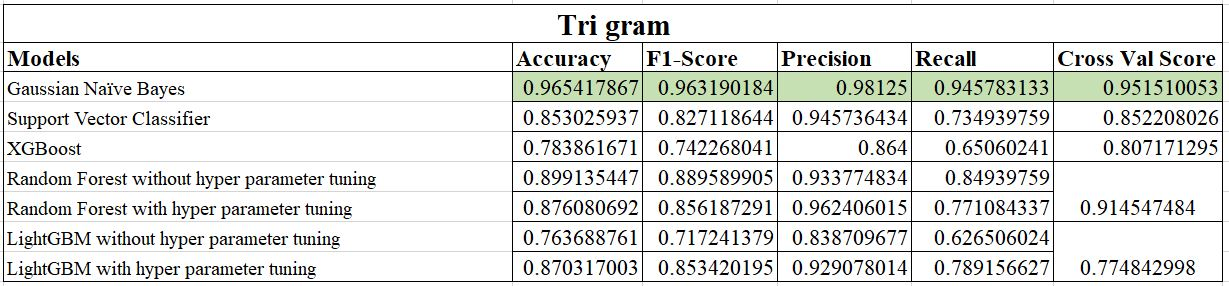

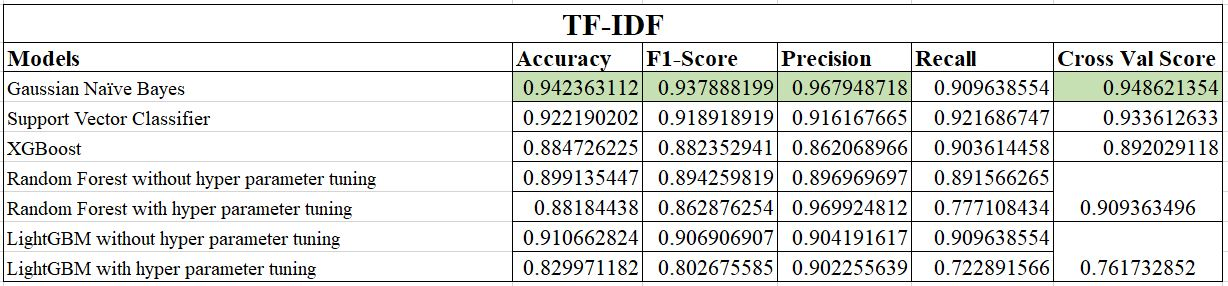